# Equation de la chaleur

In [280]:
import numpy as np
import numpy.linalg as npl
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.sparse as scs
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse.linalg as scsl

On considère l'équation de la chaleur

$$\partial_{t}u(t,x)=\mu\partial_{xx}u(t,x),~~\forall t>0,~\forall x\in ]0,1[$$

avec les conditions aux limites de Dirichlet homogènes et une condition initiale notée $u_0$.

In [96]:
# Explicit Euler :

def Euler_Exp(dt,dx,U0,Tinit,Tend,mu):
    N = int((Tend-Tinit)/dt)
    U = np.zeros((len(U0),N))
    U[:,0] = U0
    Utmp = U0.copy()
    boundaries = np.ones_like(U0,dtype=bool)
    boundaries[0] = False
    boundaries[-1] = False 
    for i in range(N):
        U[:,i]=U0 + mu*(dt/dx**2)*(np.roll(U0,+1) + np.roll(U0,-1) - 2*U0)
        U[0,i]=0
        U[len(U0)-1,i]=0
        U0=U[:,i]
    return np.array(U)

In [288]:
# Implicit Euler :

def Euler_Imp(dt,dx,U0,Tinit,Tend,mu):
    N = int(T/dt)
    X=int(L/dx)
    U = np.zeros((len(U0),N))
    U[:,0] = U0
    c = dt/(dx*dx)   
    A = np.zeros((X,X))
    I = np.identity(X)
    A[0,0] = A[X-1,X-1] = mu*2/(dx*dx)
    for i in range(1,X-1):
        A[i,i]= mu*2/(dx*dx)
        A[i,i-1] = A[i,i+1]= -mu/(dx*dx)
    Ainv = npl.inv(A*dt+I)
    for i in range(N-1):
        U[:,i+1] = np.dot(Ainv,U[:,i])
    return U

In [289]:
# Theta-scheme :

def Theta(dt,dx,U0,Tinit,Tend,mu,theta):
    N = int((Tend-Tinit)/dt)
    X = len(U0)
    U = np.zeros((X,N))
    U[:,0] = U0
    c = dt/(dx*dx)
    A = np.zeros((X,X))
    I = np.identity(X)
    A[0,0] = A[X-1,X-1] = mu*2/(dx*dx)
    for i in range(1,X-1):
        A[i,i]= mu*2/(dx*dx)
        A[i,i-1] = A[i,i+1]= -mu/(dx*dx)
    Ainv = npl.inv(I + dt*A*(1-theta))
    interm = np.zeros(X)
    for i in range(N-1):
        M = np.dot((I-dt*theta*A),Ainv)
        U[0,i] = 0
        U[X-1,i] = 0
        U[:,i+1] = np.dot(U[:,i],M)
    return U

In [290]:
Tinit  = 0                                      #init
T      = 0.3                                    #end
L      = 1                                      #space length
dt     = 0.00002                                #time step
dx     = 0.010                                  #space step
mu     = 0.3                                    #viscosité
theta  = 1/2                                    #theta
temps  = np.linspace(Tinit,T,int((T-Tinit)/dt)) #time-vector
NT     = len(temps)                             #time-vector size
espace = np.linspace(0,1,int(L/dx))             #space

scheme = 3   #1:Euler_Exp, 2:Euler_Imp, 3:Theta
cinit  = 2   #1:sinus, 2:créneau

if cinit == 1:    #sinus
    U0 = np.sin(np.pi*espace)
elif cinit == 2:  #créneau
    X = len(espace)
    U0 = np.zeros(X, dtype=float)
    U0[int(X/2-math.sqrt(X/2)):int(X/2+math.sqrt(X/2))] = 1.

if scheme == 1:
    if (mu*(dt/dx))>1:
        print("CFL condition !")
    else:
        U = Euler_Exp(dt,dx,U0,Tinit,T,mu)
elif scheme == 2:
    U = Euler_Imp(dt,dx,U0,Tinit,T,mu)   
elif scheme == 3:
    if (mu*(dt/dx))>1:
        print("CFL condition !")
    else:
        U = Theta(dt,dx,U0,Tinit,T,mu,theta)

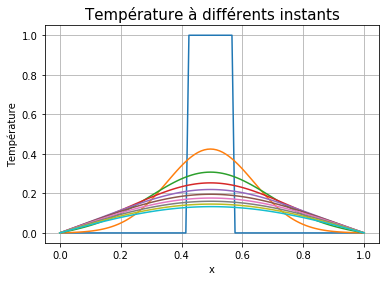

In [287]:
for i in range(10):
    t = int(NT*(i)/10)
    plt.plot(espace,U[:,t])#label="Instant {}".format(temps[t]))
plt.grid()
plt.title("Température à différents instants",fontsize = 15)
plt.ylabel("Température")
plt.xlabel("x")
plt.show()

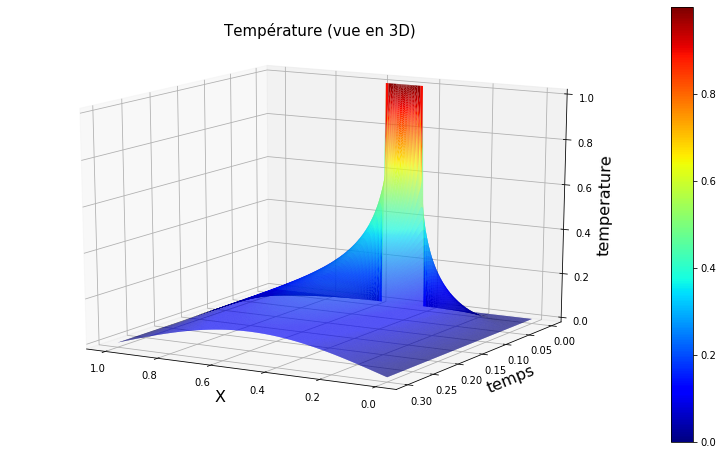

In [291]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X', fontsize = 16)
ax.set_ylabel('temps', fontsize = 16)
ax.set_zlabel('temperature', fontsize = 16)
ax.view_init(elev=15, azim = 120)

[SX,ST]=np.meshgrid(espace,temps)
a = ax.plot_surface(SX,ST,U.T,cstride=1,linewidth=0,cmap='jet')
plt.title("Température (vue en 3D)",fontsize=15)
plt.colorbar(a)
plt.show()

## Recalls

## Explicit Euler

$$\frac{U_j^{n+1}-U_j^{n}}{\delta_t}=\mu\frac{U_{j-1}^n-2U_j^n+U_{j+1}^n}{\delta_x^2}$$

s.t.

$$U_j^{n+1}=U_j^{n} + \mu\frac{\delta_t}{\delta_x^2}(U_{j-1}^n-2U_j^n+U_{j+1}^n)$$

## Implicit Euler

$$\frac{U_j^{n+1}-U_j^{n}}{\delta_t}=\mu\frac{U_{j-1}^{n+1}-2U_j^{n+1}+U_{j+1}^{n+1}}{\delta_x^2}$$

## Theta-scheme

$$\frac{U_j^{n+1}-U_j^{n}}{\delta_t}=\mu(1-\theta)\frac{U_{j-1}^{n+1}-2U_j^{n+1}+U_{j+1}^{n+1}}{\delta_x^2}+\mu\theta\frac{U_{j-1}^{n}-2U_j^{n}+U_{j+1}^{n}}{\delta_x^2}$$

On se donne le problème stationnaire 1D suivant:
$$\begin{cases}
    \lambda(x) u''(x) = 0 \; , \; \forall x \in [0;1]\\
    u(0)=T_0\; , \; u(1)=0\\
\end{cases}$$.
Avec : $$\lambda(x) = \begin{cases}
        \lambda_0 \; , \; \text{si } x \in[0;\frac{1}{2}]\\
        1 \; , \; \text{si } x \in[\frac{1}{2};1]\\
\end{cases}$$.
Les paramètres de ce problème sont alors:
$$\mu = (\lambda_0, T_0) \in \mathbb{R}\times \mathbb{R}$$

In [12]:
import scipy as sp
import numpy as np
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt

In [13]:
def second_membre_nul(x,mu):
    coucou = np.zeros(len(x))
    coucou[0] = mu[1]
    return coucou

#résolution par diff finies
def solver(n,second_membre,mu):
    # mu = [lambda_0, T_0]
    N_diff = 2**n
    x_diff_plot = sp.linspace(0,1,N_diff+2)
    x_diff = x_diff_plot[:-1]
    f_diff = second_membre(x_diff,mu)

    #construction de la matrice A en format sparse
    tab_A_0 = [np.repeat([1,0],[N_diff//2,N_diff//2],0),np.repeat([0,-2,-1,0],[1,N_diff//2-1,1,N_diff//2],0),np.repeat([0,1,0],[1,N_diff//2-1,N_diff//2],0)]
    tab_A_1 = [np.repeat([0,((N_diff+2)**2)],[N_diff//2,N_diff//2],0),np.repeat([1,0,-((N_diff+2)**2),-2*((N_diff+2)**2)],[1,N_diff//2-1,1,N_diff//2],0),np.repeat([0,((N_diff+2)**2)],[N_diff//2,N_diff//2],0)]
    A_0 = sp.sparse.diags(tab_A_0,[-1,0,1],(N_diff+1,N_diff+1))*mu[0]*((N_diff+2)**2)
    A_1 = sp.sparse.diags(tab_A_1,[-1,0,1],(N_diff+1,N_diff+1))
    #NPA_0 = A_0.todense()
    #NPA_1 = A_1.todense()
    #print(NPA_0+NPA_1)
    #print(NPA_1)

    #résolution des diff finies (Au=f)
    U_diff = spspl.spsolve(A_0+A_1,f_diff)

    #préparation au plot
    U_diff_plot = sp.zeros(N_diff+2)
    U_diff_plot[:-1] = U_diff
    
    return x_diff_plot, U_diff_plot
        

In [14]:
X,U1 = solver(5,second_membre_nul,[200,50])
_,U2 = solver(5,second_membre_nul,[0.8,50])
_,U3 = solver(5,second_membre_nul,[0.1,50])

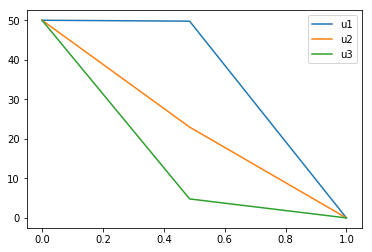

In [15]:
plt.plot(X,U1,label="u1")
plt.plot(X,U2,label="u2")
plt.plot(X,U3,label="u3")
plt.legend()
plt.show()